In [1]:
# !pip install ipympl
# %pip install pandas
# %pip install noise

In [2]:
#%matplotlib widget

# imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from dataclasses import dataclass, field
import random
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from noise import pnoise2, pnoise1
from scipy.stats import linregress
from scipy.spatial import KDTree
import matplotlib

# implementations

L is transformation of argument of interpolated function

Simply scale $[0; 1]^2$ into lesser square. Let's denote it with $L'_{ij}$.

In [4]:
@dataclass
class L_prime:
    i: int
    j: int
    n: int
    
    def get(self, t1, t2):
        global n
        
        t1_new = t1 / self.n + (self.i - 1) / self.n
        t2_new = t2 / self.n + (self.j - 1) / self.n
        
        return t1_new, t2_new

This is how argument transformation was defined on lectures presentations. Let's denote it with $L_{ij}$.

In [5]:
@dataclass
class L:
    i: int
    j: int
    n: int
    
    def get(self, t1, t2):
        global n
        
        t1_new = (-1 if (self.i + 1) % 2 == 1 else 1) / self.n * t1 + (self.i - self.i % 2) / self.n
        t2_new = (-1 if (self.j + 1) % 2 == 1 else 1) / self.n * t2 + (self.j - self.j % 2) / self.n
        
        return t1_new, t2_new

Transformation for values.

In [6]:
@dataclass
class F:
    a: float
    b: float
    c: float
    d: float
    f: float

    def get(self, t1, t2, x):
        return self.d * x + self.a * t1 + self.b * t2 + self.c * t1 * t2 + self.f

Class to store both transformations

In [7]:
@dataclass
class W:
    L: L
    F: F

# difference between defined argument transformations

Now to visualise the difference between two argument transformations

In [8]:
n = 10
unit_interval = np.linspace(0, 1, n + 1)

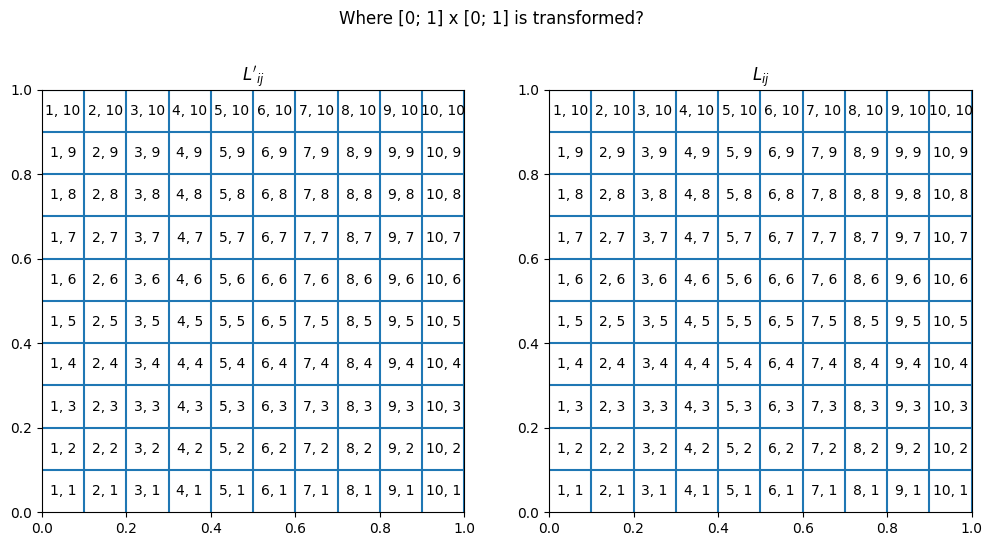

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for i in range(1, n + 1):
    for j in range(1, n + 1):
        l = L_prime(i, j, n)
        ax[0].text(*l.get(0.5, 0.5), f'{i}, {j}', horizontalalignment='center', verticalalignment='center')
    ax[0].axhline(y=i/n)
    ax[0].axvline(x=i/n)
ax[0].set_aspect('equal')
ax[0].set_title('$L\'_{ij}$')

for i in range(1, n + 1):
    for j in range(1, n + 1):
        l = L(i, j, n)
        ax[1].text(*l.get(0.5, 0.5), f'{i}, {j}', horizontalalignment='center', verticalalignment='center')
    ax[1].axhline(y=i/n)
    ax[1].axvline(x=i/n)
ax[1].set_aspect('equal')
ax[1].set_title('$L_{ij}$')

fig.suptitle('Where [0; 1] x [0; 1] is transformed?')

plt.show()

So both $L'_{ij}$ and $L_{ij}$ transform $[0; 1]^2$ into $[\frac{i - 1}{n}; \frac{i}{n}] \times [\frac{j - 1}{n}; \frac{j}{n}]$.

But are images of $L'_{ij}$ and $L_{ij}$ actually identical? Let's check.

Function to generate image based on coordinates.

In [10]:
def gradient_image(X, Y):
    '''
    - X is matrix of x values repeated across y axis
    - Y is matrix of y values repeated across x axis
    '''

    # standarise X
    X = X - X.min()
    X = X / X.max()
    # standarise Y
    Y = Y - Y.min()
    Y = Y / Y.max()

    # based on X and Y return matrix containing lengths to that points
    return np.sqrt(X ** 2 + Y ** 2)

Let's see images of transformations $L'_{ij}([0; 1]^2)$.

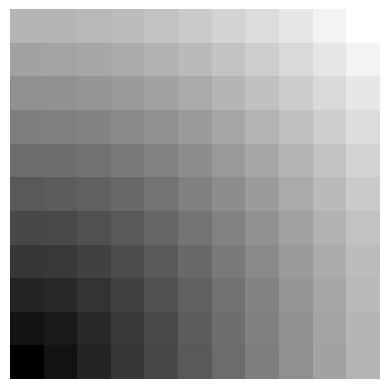

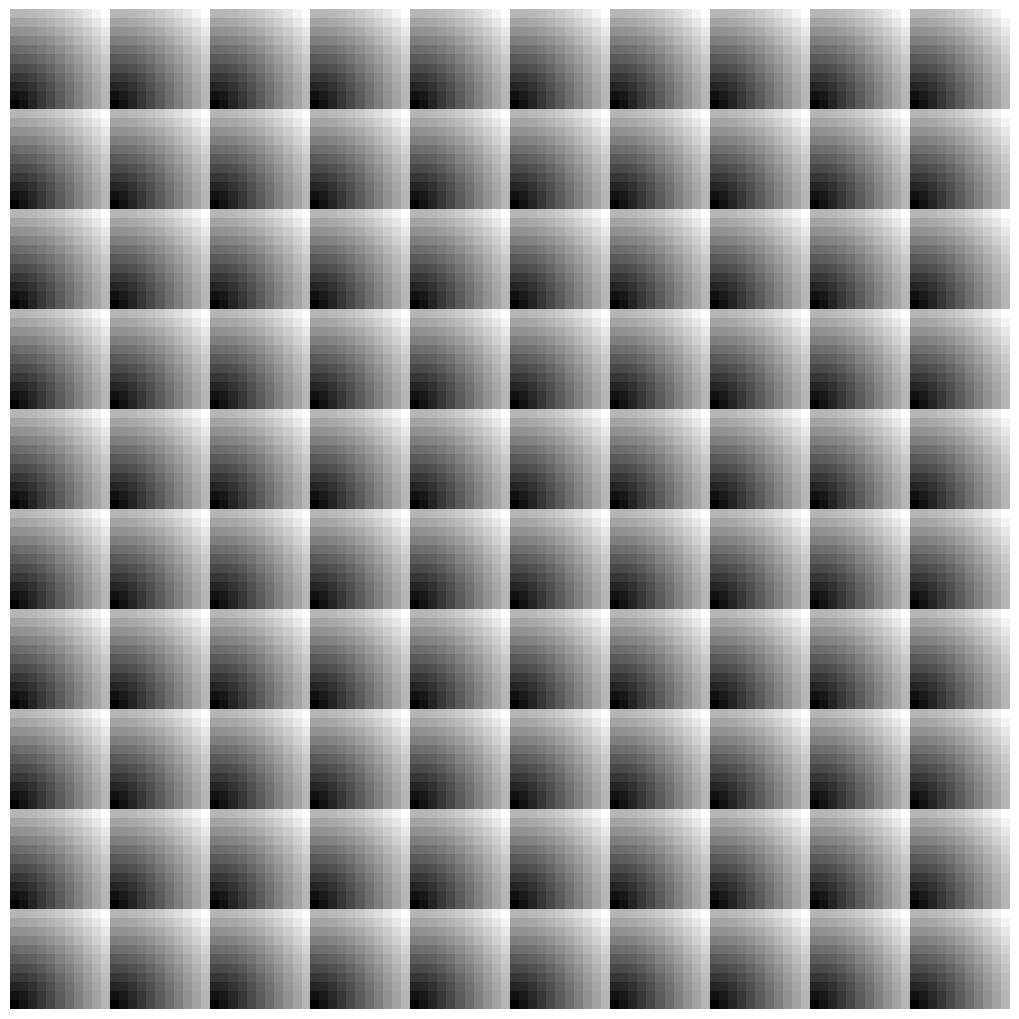

In [11]:
# show reference image
X, Y = np.meshgrid(unit_interval, unit_interval)
plt.imshow(gradient_image(X, Y), cmap='gray', origin='lower')
plt.axis('off')
plt.show()

# create n^2 subplots for all n^2 transformations
fig, ax = plt.subplots(nrows=n, ncols=n, figsize=(10, 10))

for i in range(1, n + 1):
    for j in range(1, n + 1):
        # initialise transformation
        l = L_prime(i, j, n)
        # create image based on transformed square
        ax[i - 1][j - 1].imshow(gradient_image(*l.get(*np.meshgrid(unit_interval, unit_interval))), cmap='gray', origin='lower')
        # hide axis
        ax[i - 1][j - 1].axis('off')
# remove spacings
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
# show
plt.show()
plt.close()

Let's see images of transformations $L_{ij}([0; 1]^2)$.

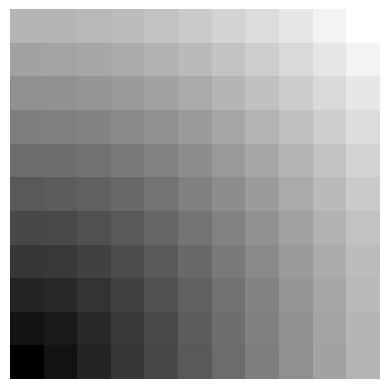

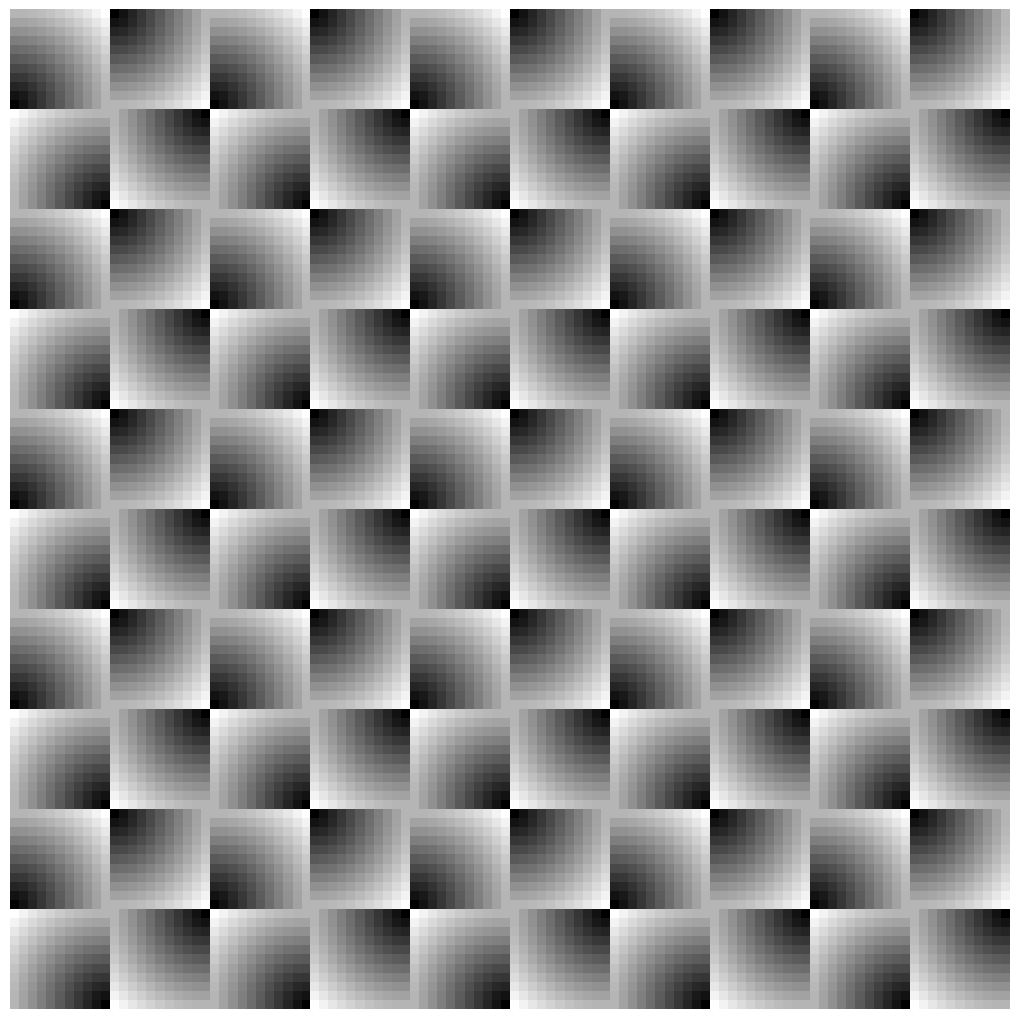

In [12]:
# show reference image
X, Y = np.meshgrid(unit_interval, unit_interval)
plt.imshow(gradient_image(X, Y), cmap='gray', origin='lower')
plt.axis('off')
plt.show()

# create n^2 subplots for all n^2 transformations
fig, ax = plt.subplots(nrows=n, ncols=n, figsize=(10, 10))

for i in range(1, n + 1):
    for j in range(1, n + 1):
        # initialise transformation
        l = L(i, j, n)
        # create image based on transformed square
        ax[i - 1][j - 1].imshow(gradient_image(*l.get(*np.meshgrid(unit_interval, unit_interval))), cmap='gray', origin='lower')
        # hide axis
        ax[i - 1][j - 1].axis('off')
# remove spacings
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
# show
plt.show()
plt.close()

Welp, they are indeed different.

# IFS

calculate coefficients for F

In [13]:
def coefficients(d, x_00, x_0n, x_n0, x_nn, x_l_00, x_l_01, x_l_10, x_l_11):
    f = x_l_00 - d * x_00
    a = x_l_10 - d * x_n0 - f
    b = x_l_01 - d * x_0n - f
    c = x_l_11 - d * x_nn - f - a - b
    
    return a, b, c, f

IFS function itself

In [14]:
def ifs(initial_points, n, N=20000, d=0.5):
    # retrieve several points
    x_00 = initial_points.loc[(initial_points['i'] == 0) & (initial_points['j'] == 0), 'y'].item()
    x_0n = initial_points.loc[(initial_points['i'] == 0) & (initial_points['j'] == n), 'y'].item()
    x_n0 = initial_points.loc[(initial_points['i'] == n) & (initial_points['j'] == 0), 'y'].item()
    x_nn = initial_points.loc[(initial_points['i'] == n) & (initial_points['j'] == n), 'y'].item()

    # initialise matrix of transformations
    transformations = [[None for j in range(n + 1)] for i in range(n + 1)]
    for i in range(1, n + 1):
        for j in range(1, n + 1):
            # retrieve transformation specific points
            x_l_00 = initial_points.loc[(initial_points['i'] == i - i % 2) & (initial_points['j'] == j - j % 2), 'y'].item()
            x_l_01 = initial_points.loc[(initial_points['i'] == (-1 if (i + 1) % 2 == 1 else 1) + i - i % 2) & (initial_points['j'] == j - j % 2), 'y'].item()
            x_l_10 = initial_points.loc[(initial_points['i'] == i - i % 2) & (initial_points['j'] == (-1 if (j + 1) % 2 == 1 else 1) + j - j % 2), 'y'].item()
            x_l_11 = initial_points.loc[(initial_points['i'] == (-1 if (i + 1) % 2 == 1 else 1) + i - i % 2) & (initial_points['j'] == (-1 if (j + 1) % 2 == 1 else 1) + j - j % 2), 'y'].item()

            # calculate coefficients
            a, b, c, f = coefficients(d, x_00, x_0n, x_n0, x_nn, x_l_00, x_l_01, x_l_10, x_l_11)

            # instantiate W object by passing arguments
            transformations[i][j] = W(L(i, j, n), F(a, b, c, d, f))

    # result list of IFS-generated poitns, first one is the first one from initial_points DataFrame
    result = [initial_points.loc[0, ['x1', 'x2', 'y']].tolist()]

    # while we do not have desired number of points
    while len(result) < N:
        # randomly acquire indexes for transformation
        i = random.randint(1,n)
        j = random.randint(1,n)
        t = transformations[i][j]

        # get new 3d-point from transformation based on the last point available in result list and append it to the end
        result.append((*t.L.get(result[-1][0], result[-1][1]), t.F.get(*result[-1])))
    
    return result

# data generation

In [15]:
def generate(func, n):
    unit_interval = np.linspace(0, 1, n + 1)
    
    data = [None for _ in range((n + 1) ** 2)]
    for i in range(n + 1):
        for j in range(n + 1):
            data[i * (n + 1) + j] = (i, j, unit_interval[i], unit_interval[j])
    df = pd.DataFrame.from_dict(data, orient='columns').rename(columns={0: 'i', 1: 'j', 2: 'x1', 3: 'x2'})
    df['y'] = func(df['x1'], df['x2'])

    return df

# some examples

In [16]:
def example_custom_df(df, cmap_name='copper_r', surface_plot=False):
    if surface_plot:
        X1, X2 = np.meshgrid(df['x1'].unique(), df['x2'].unique())
        dim = df['i'].max().item() + 1
        Y = df['y'].values.reshape(dim, dim)
        
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.plot_surface(X1, X2, Y, cmap=plt.get_cmap(cmap_name), linewidth=0, antialiased=True)
    else:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(df['x1'], df['x2'], df['y'], cmap=plt.get_cmap(cmap_name), c=df['y'], s=60)
    plt.show()
    
    points = pd.DataFrame.from_dict(ifs(df, 2)).rename(columns={0: 'x1', 1: 'x2', 2: 'y'})
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(points['x1'], points['x2'], points['y'], cmap=plt.get_cmap(cmap_name), c=points['y'], s=6)
    plt.show()

In [17]:
def example(func, n, N=20000, d=0.5, verbose=False, show_plots=False):
    df = generate(func, n)

    if verbose:
        print(df)

    if show_plots:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(df['x1'], df['x2'], df['y'], cmap='gist_earth', c=df['y'], s=6)
        plt.show()

    points = pd.DataFrame.from_dict(ifs(df, n, N, d)).rename(columns={0: 'x1', 1: 'x2', 2: 'y'})

    if show_plots:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(points['x1'], points['x2'], points['y'], cmap='gist_earth', c=points['y'], s=6)
        plt.show()

    return points

example with pyramid

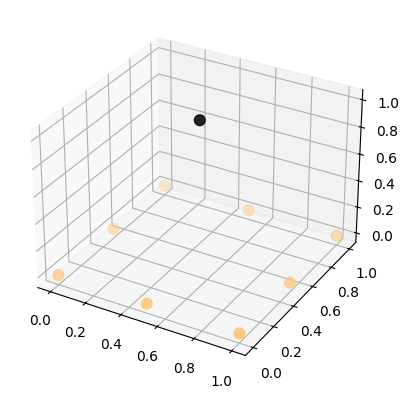

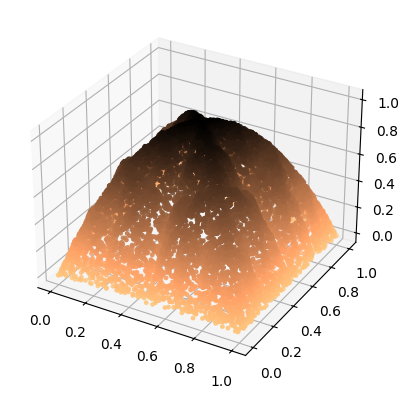

In [18]:
df_pyramid = pd.DataFrame.from_dict(    {
        'i': [0, 1, 2, 0, 1, 2, 0, 1, 2],
        'j':[0, 0, 0, 1, 1, 1, 2, 2, 2],
        'x1': [0, 0.5, 1, 0, 0.5, 1, 0, 0.5, 1],
        'x2': [0, 0, 0, 0.5, 0.5, 0.5, 1, 1, 1],
        'y': [0, 0, 0, 0, 1, 0, 0, 0, 0]
    }, orient='columns')
example_custom_df(df_pyramid)

example with sea

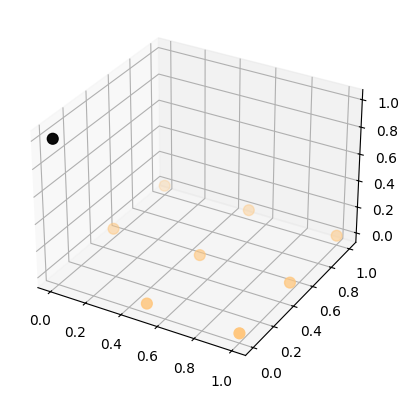

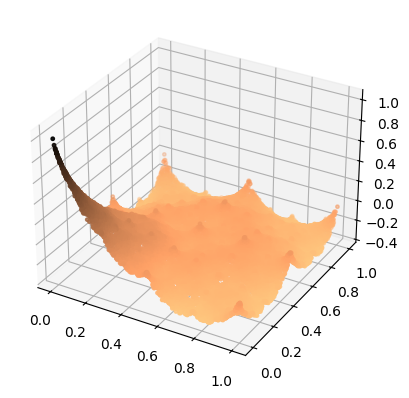

In [19]:
df_sea = pd.DataFrame.from_dict(    {
        'i': [0, 1, 2, 0, 1, 2, 0, 1, 2],
        'j':[0, 0, 0, 1, 1, 1, 2, 2, 2],
        'x1': [0, 0.5, 1, 0, 0.5, 1, 0, 0.5, 1],
        'x2': [0, 0, 0, 0.5, 0.5, 0.5, 1, 1, 1],
        'y': [1, 0, 0, 0, 0, 0, 0, 0, 0]
    }, orient='columns')
example_custom_df(df_sea)

example with droplet

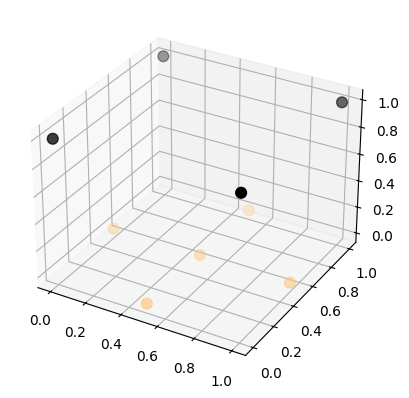

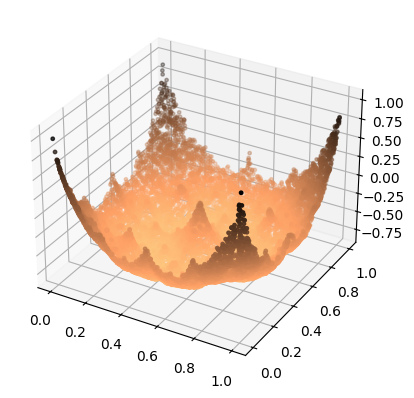

In [20]:
df_droplet = pd.DataFrame.from_dict(    {
        'i': [0, 1, 2, 0, 1, 2, 0, 1, 2],
        'j':[0, 0, 0, 1, 1, 1, 2, 2, 2],
        'x1': [0, 0.5, 1, 0, 0.5, 1, 0, 0.5, 1],
        'x2': [0, 0, 0, 0.5, 0.5, 0.5, 1, 1, 1],
        'y': [1, 0, 1, 0, 0, 0, 1, 0, 1]
    }, orient='columns')
example_custom_df(df_droplet)

example with random values from normal distribution

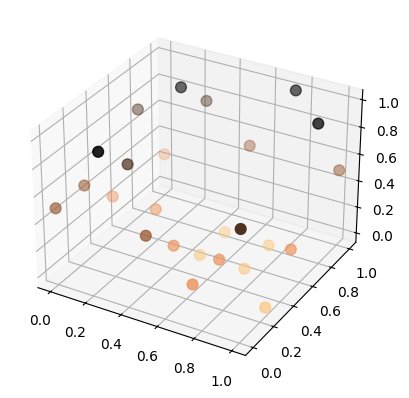

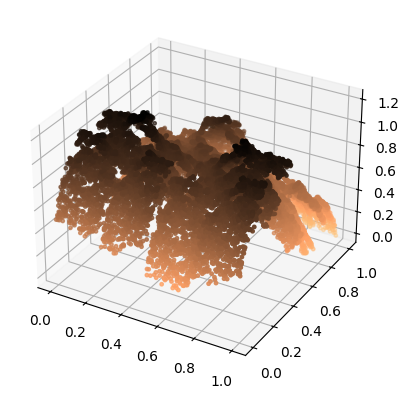

In [21]:
np.random.seed(123)
df_test = pd.DataFrame.from_dict(    {
        'i': [0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4],
        'j': [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4],
        'x1': [0, 0.25, 0.5, 0.75, 1, 0, 0.25, 0.5, 0.75, 1, 0, 0.25, 0.5, 0.75, 1, 0, 0.25, 0.5, 0.75, 1, 0, 0.25, 0.5, 0.75, 1],
        'x2': [0, 0, 0, 0, 0, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 1, 1, 1, 1, 1],
        'y': np.linspace(0, 1, 5)[np.random.choice(5, size=25)].tolist()
    }, orient='columns')
example_custom_df(df_test)

example with random values from 0 to 1 by 0.25

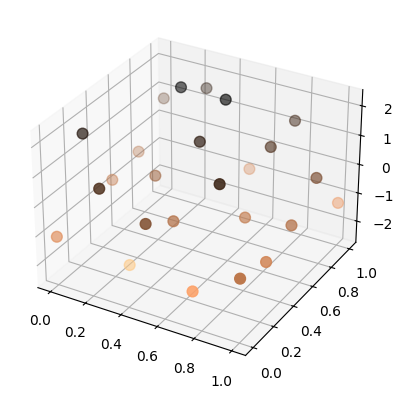

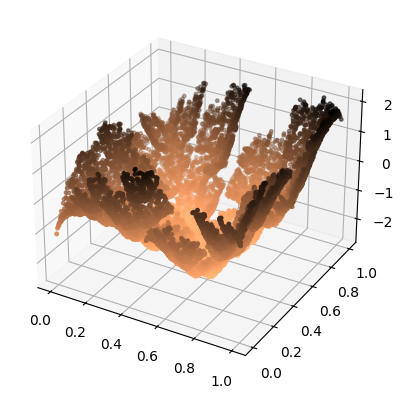

In [22]:
np.random.seed(123)
df_test = pd.DataFrame.from_dict(    {
        'i': [0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4],
        'j': [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4],
        'x1': [0, 0.25, 0.5, 0.75, 1, 0, 0.25, 0.5, 0.75, 1, 0, 0.25, 0.5, 0.75, 1, 0, 0.25, 0.5, 0.75, 1, 0, 0.25, 0.5, 0.75, 1],
        'x2': [0, 0, 0, 0, 0, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 1, 1, 1, 1, 1],
        'y': np.random.normal(0, 1, 25).tolist()
    }, orient='columns')
example_custom_df(df_test)

how interpolation works based on n

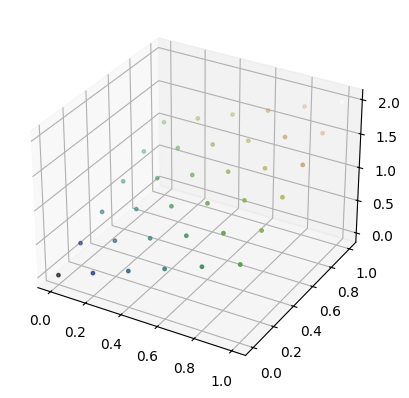

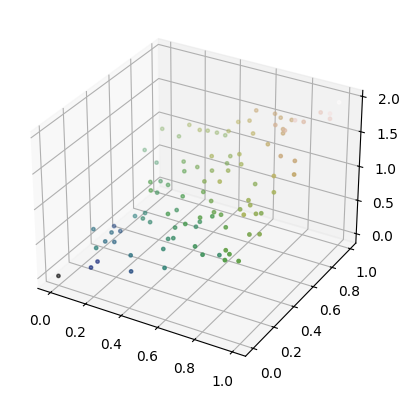

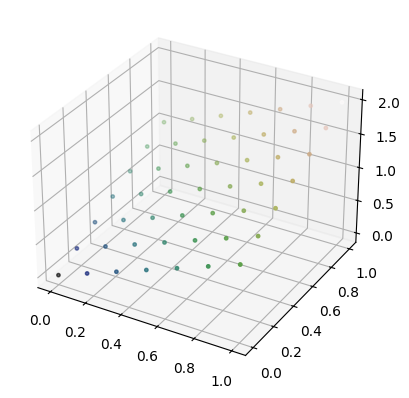

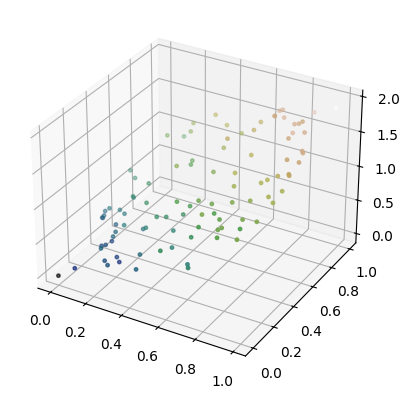

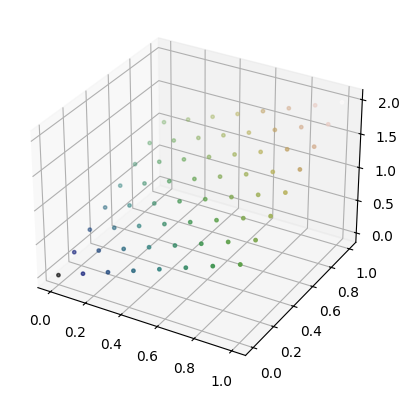

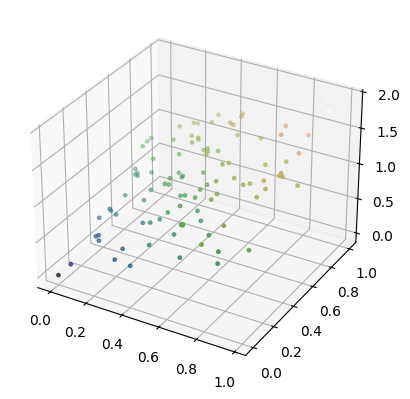

In [23]:
for i in range(5, 8):
    points = example(lambda x1, x2: x1 + x2, i, N=100, show_plots=True)

addition

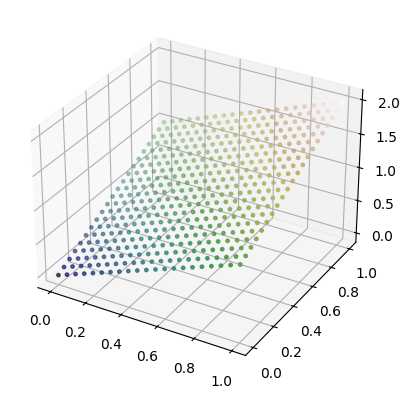

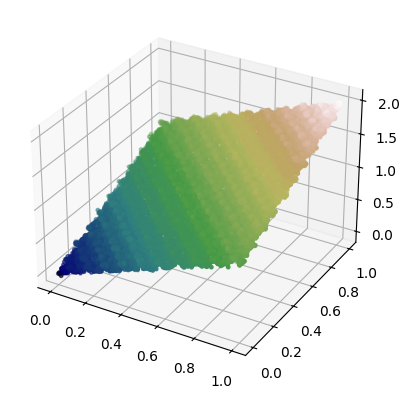

In [24]:
points = example(lambda x1, x2: x1 + x2, 20, show_plots=True)

multiplication

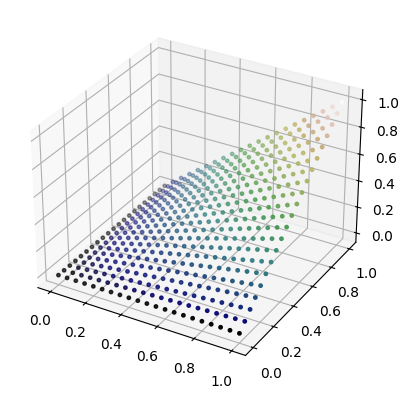

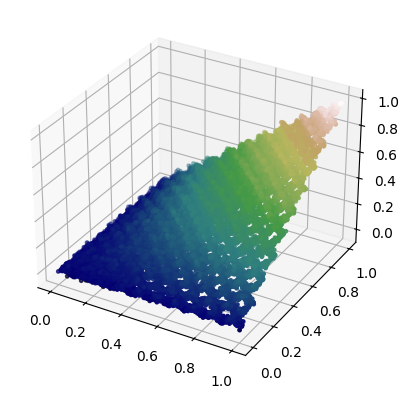

In [25]:
points = example(lambda x1, x2: x1 * x2, 20, show_plots=True)

sum of squares

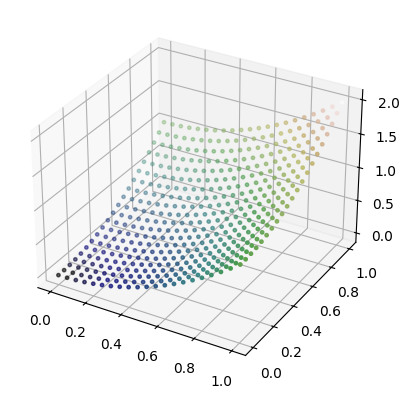

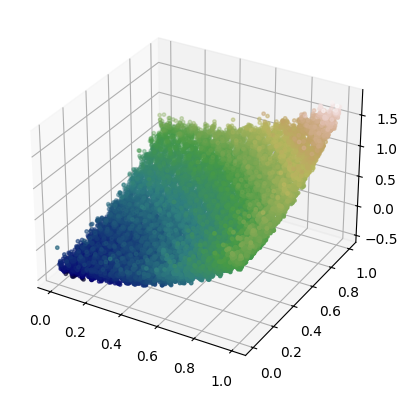

In [26]:
points = example(lambda x1, x2: x1 ** 2 + x2 ** 2, 20, show_plots=True)

sine of sum of squares

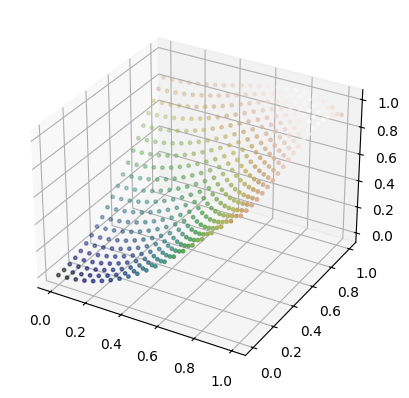

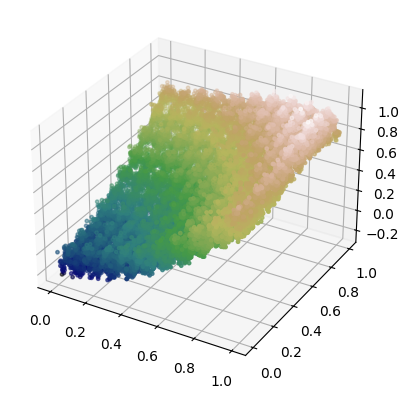

In [27]:
points = example(lambda x1, x2: np.sin(x1 ** 2 + x2 ** 2), 20, show_plots=True)

# Brownian motion

In [28]:
# Rysunek 2D

def rysunek_2D(surface, title):
    
    plt.figure(figsize=(10, 8))
    plt.imshow(surface, cmap='terrain')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Rysunek 3D

def rysunek_3D(surface, title):
    width = surface.shape[1]
    height = surface.shape[0]
    
    # Generowanie współrzędnych siatki
    x = np.linspace(0, 1, width)
    y = np.linspace(0, 1, height)
    x, y = np.meshgrid(x, y)

    # Tworzenie wykresu 3D
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Rysowanie powierzchni
    surf = ax.plot_surface(x, y, surface, cmap='gist_earth',  linewidth=0, antialiased=False)

    # Dodanie paska kolorów
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    # Ustawienia wykresu
    ax.set_title(title)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Height')

    plt.show()

In [29]:
# functions based on code shared during labs and medium article: https://miquelvir.medium.com/procedural-fractal-terrains-with-python-how-does-minecraft-generate-infinite-maps-hands-on-36ab94155160
def diamond_square(size, scale=1.0, ratio=0.5):
    # Inicjalizacja tablicy
    arr = np.zeros((size + 1, size + 1))
    
    # Ustawianie narożników
    arr[0, 0] = arr[0, -1] = arr[-1, 0] = arr[-1, -1] = scale

    def diamond(x, y, size, scale):
        avg = (arr[x, y] + arr[x + size, y] + arr[x, y + size] + arr[x + size, y + size]) / 4.0
        arr[x + size // 2, y + size // 2] = avg + np.random.uniform(-scale, scale)

    def square(x, y, size, scale):
        s2 = size // 2
        a1 = arr[x + s2, y] = (arr[x, y] + arr[x + size, y]) / 2 + np.random.uniform(-scale, scale)
        a2 = arr[x, y + s2] = (arr[x, y] + arr[x, y + size]) / 2 + np.random.uniform(-scale, scale)
        a3 = arr[x + size, y + s2] = (arr[x + size, y] + arr[x + size, y + size]) / 2 + np.random.uniform(-scale, scale)
        a4 = arr[x + s2, y + size] = (arr[x, y + size] + arr[x + size, y + size]) / 2 + np.random.uniform(-scale, scale)
        arr[x + s2, y + s2] = (a1 + a2 + a3 + a4) / 4 + np.random.uniform(-scale, scale)

    step_size = size
    while step_size > 1:
        half_step = step_size // 2

        for y in range(0, size, step_size):
            for x in range(0, size, step_size):
                diamond(x, y, step_size, scale)

        for y in range(0, size, step_size):
            for x in range(0, size, step_size):
                square(x, y, step_size, scale)

        step_size = step_size // 2
        scale *= ratio

    return arr

def fbm2D(H, shape=(256, 256), length=(1, 1), p=0):
    """
    Generowanie 2D powierzchnii ułamkowych ruchów Browna (Fractional Brownian Motion) na prostokącie
    o wymiarach shape i o współczynniku Hursta 'H'.
    """
    
    # np.random.seed(0)
    norm.ppf(0.5 + np.random.rand(4))

    n, m = shape
    N, M = n + p * (n - 1), m + p * (m - 1)
    Lx, Ly = length

    ky = np.fft.fftfreq(N) * 2 * np.pi / Lx
    kx = np.fft.fftfreq(M) * 2 * np.pi / Ly
    kx[0], ky[0] = kx[1], ky[1]
    
    KX, KY = np.meshgrid(kx, ky)

    K = np.sqrt(KX**2 + KY**2)
    K[0, 0] = 1.
    sK = K**(-H - 1)

    hW = np.fft.fft2(np.random.randn(*K.shape)) * sK

    h = np.fft.ifft2(hW).real

    h = h[:n, :m]
    
    return h / np.std(h)

def perlin(width=1024, height=1024, scale=100.0, octaves=6, persistence=0.5, lacunarity=2.0):
    landscape_perlin = np.zeros((width, height))
    for i in range(width):
        for j in range(height):
            landscape_perlin[i][j] = pnoise2(i / scale, 
                                                j / scale, 
                                                octaves=octaves, 
                                                persistence=persistence, 
                                                lacunarity=lacunarity, 
                                                repeatx=width, 
                                                repeaty=height, 
                                                base=42)
    return landscape_perlin

def perlin_with_fbm(start=200, stop=300, step=0.1, perlin_frequency=0.05, perlin_amplitude=1, fbm_octaves=4, fbm_lacunarity=2, fbm_h=0.1):
    xx = np.arange(start, stop, step)
    shape = (xx.size, xx.size)
    
    landscape = np.zeros(shape)
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            A, f = perlin_amplitude, perlin_frequency
            for o in range(fbm_octaves):
                A *= fbm_lacunarity**(-fbm_h*o)
                landscape[i][j] += A * pnoise2(f*xx[i], f*xx[j])
                f *= fbm_lacunarity
    
    return landscape

In [30]:
def convert_surface_to_points(arr):
    n, m = arr.shape
    unit_interval_1 = np.linspace(0, 1, n )
    unit_interval_2 = np.linspace(0, 1, m )

    data = [None for _ in range((n) * (m))]
    for i in range(n):
        for j in range(m):
            data[i * m + j] = (i, j, unit_interval_1[i], unit_interval_2[j], arr[i, j])
    df = pd.DataFrame.from_dict(data, orient='columns').rename(columns={0: 'i', 1: 'j', 2: 'x1', 3: 'x2', 4: 'y'})
    return df

def convert_points_to_surface(df):
    pivoted = df.pivot(index='i', columns='j', values='y')
    return pivoted.values.astype(float)  


In [31]:
arr = np.array([[1.4, 2, 4], [7, 8, 12]])
df = convert_surface_to_points(arr)
print(df)
print(convert_points_to_surface(df))
# print(convert_surface_to_points(convert_surface_to_points(arr)))

   i  j   x1   x2     y
0  0  0  0.0  0.0   1.4
1  0  1  0.0  0.5   2.0
2  0  2  0.0  1.0   4.0
3  1  0  1.0  0.0   7.0
4  1  1  1.0  0.5   8.0
5  1  2  1.0  1.0  12.0
[[ 1.4  2.   4. ]
 [ 7.   8.  12. ]]


In [32]:
arr = diamond_square(16, scale=1.0, ratio=0.5)
print(arr.shape)
d = convert_surface_to_points(arr)
d2 = ifs(d, 2)
print(d.shape)
d.head()

(17, 17)
(289, 5)


i  j   x1      x2         y
0  0  0  0.0  0.0000  1.000000
1  0  1  0.0  0.0625  0.843819
2  0  2  0.0  0.1250  0.844187
3  0  3  0.0  0.1875  0.660791
4  0  4  0.0  0.2500  0.593942

In [33]:
def interpolate_landscape(arr, n, show_plots=False, Ns=[20000], d=0.5, method='fbm', seed=42):
    np.random.seed(seed)
    random.seed(seed)
    df = convert_surface_to_points(arr)
    if show_plots:
        fig = plt.figure(figsize=(12, 6))
        fig.suptitle(f'{method} before Interpolation')
        
        # Subplot 1: Scatter plot
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.scatter(df['x1'], df['x2'], df['y'], linewidth=0.1, cmap='gist_earth', c=df['y'], s=6)
        ax1.set_title('Scatter Plot')
        ax1.set_xlabel('X axis')
        ax1.set_ylabel('Y axis')
        ax1.set_zlabel('Height')
        
        # Subplot 2: 3D surface plot
        surface = arr
        width = surface.shape[1]
        height = surface.shape[0]
        
        # Generating grid coordinates
        x = np.linspace(0, 1, width)
        y = np.linspace(0, 1, height)
        x, y = np.meshgrid(x, y)
        
        ax2 = fig.add_subplot(122, projection='3d')
        surf = ax2.plot_surface(x, y, surface, cmap='gist_earth', linewidth=0, antialiased=False)
        ax2.set_title('3D Surface Plot')
        ax2.set_xlabel('X axis')
        ax2.set_ylabel('Y axis')
        ax2.set_zlabel('Height')
        
        # Add colorbar
        fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=5)
        
        plt.show()
    points_list = []
    
    # Loop through the N values and generate the points dataframes
    for i, N in enumerate(Ns):
        points = pd.DataFrame.from_dict(ifs(df, n, N, d)).rename(columns={0: 'x1', 1: 'x2', 2: 'y'})
        points_list.append(points)
        
        # Create a new subplot for the current points dataframe
    if show_plots:
        # num_rows = (len(Ns) + 2) // 3  # Determine the number of rows needed
        fig2, axes = plt.subplots(1, len(Ns), figsize=(18, 6 * 1), subplot_kw={'projection': '3d'})
        for i, points in enumerate(points_list):
            ax = axes[i]
            # Plot the points
            ax.scatter(points['x1'], points['x2'], points['y'], linewidth=0.1, cmap='gist_earth', c=points['y'], s=6)
            ax.set_title(f'Points (N={int(Ns[i])})')
            ax.set_xlabel('X axis')
            ax.set_ylabel('Y axis')
            ax.set_zlabel('Height')

        fig2.subplots_adjust(wspace=0.5, hspace=0.5)
        fig2.suptitle(f'{method} after Interpolation')
        plt.show()
    
    return points_list

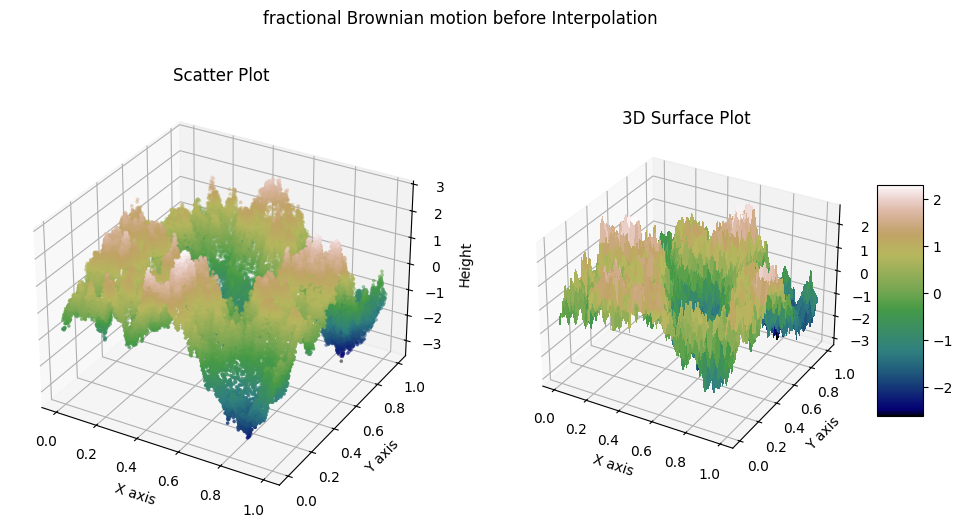

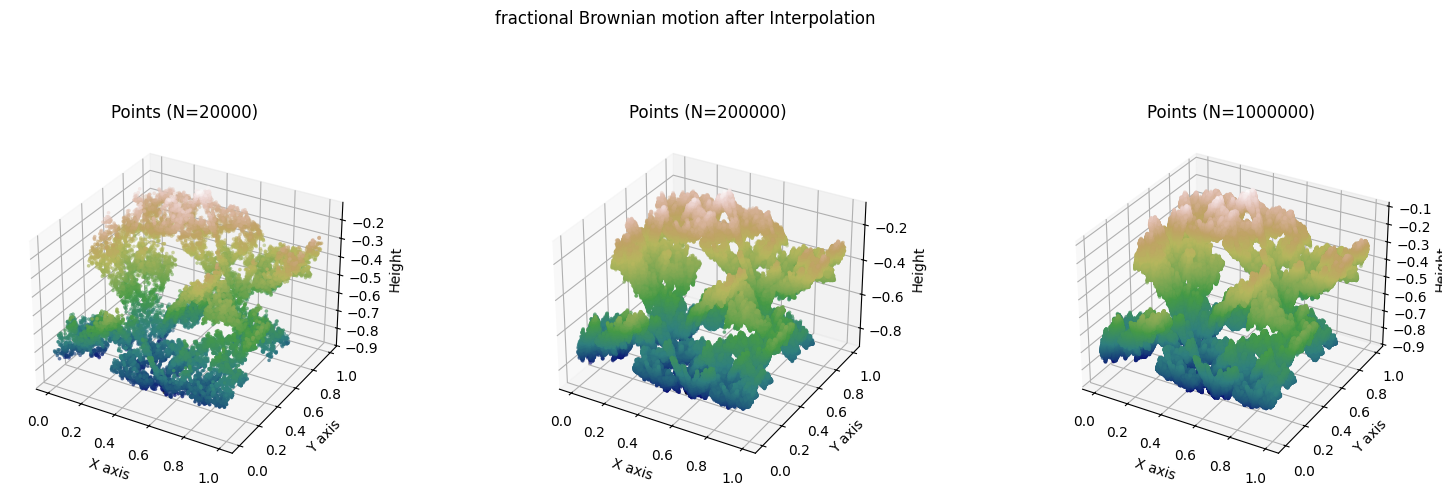

In [34]:
fbm_landscape = fbm2D(0.5, shape=(256, 256), length=(1, 1), p=0)
points = interpolate_landscape(fbm_landscape, 3, show_plots=True, Ns=[2e4, 2e5, 1e6], method='fractional Brownian motion')

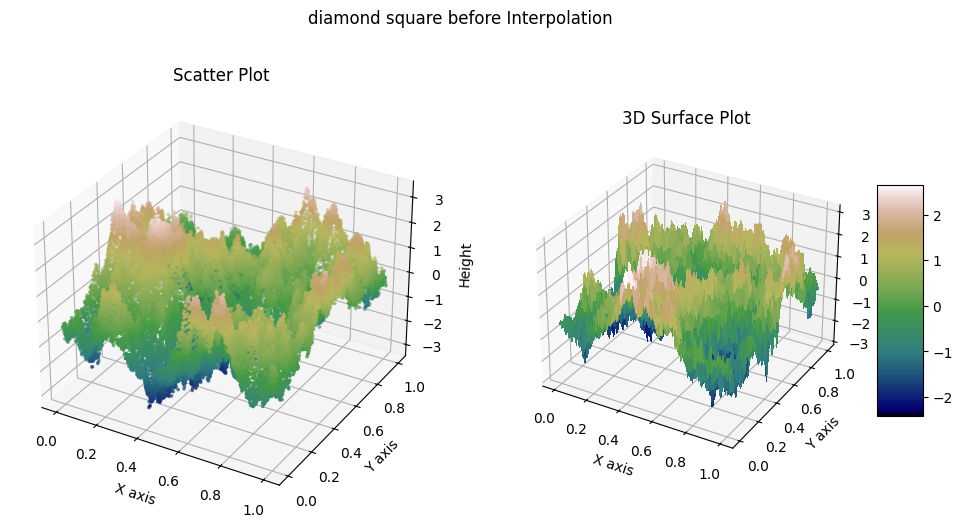

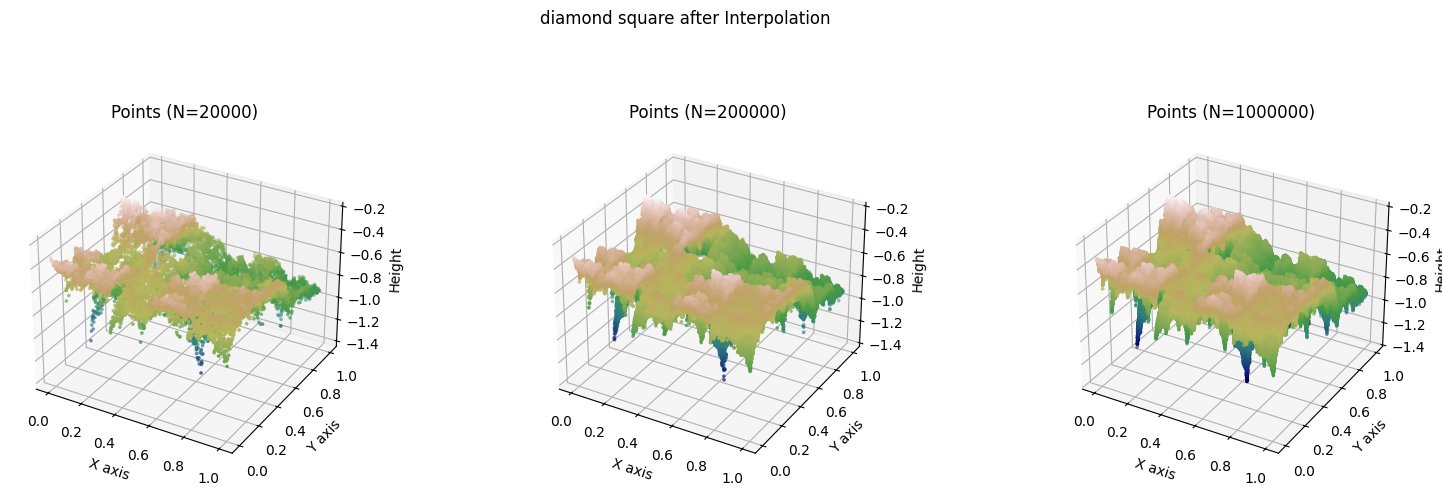

In [35]:
diamond_square_landscape = fbm2D(0.5, shape=(256, 256), length=(1, 1), p=0)
points = interpolate_landscape(diamond_square_landscape, 3, show_plots=True, Ns=[2e4, 2e5, 1e6], method='diamond square')

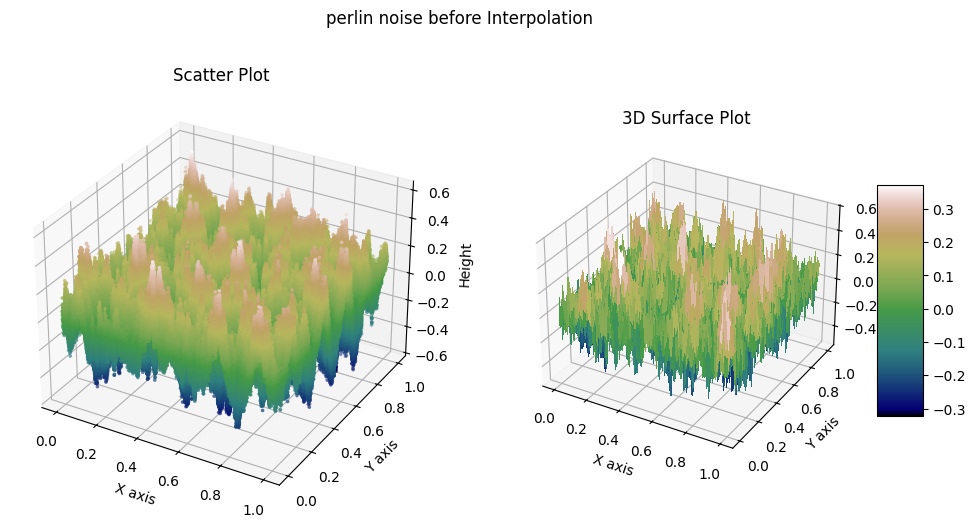

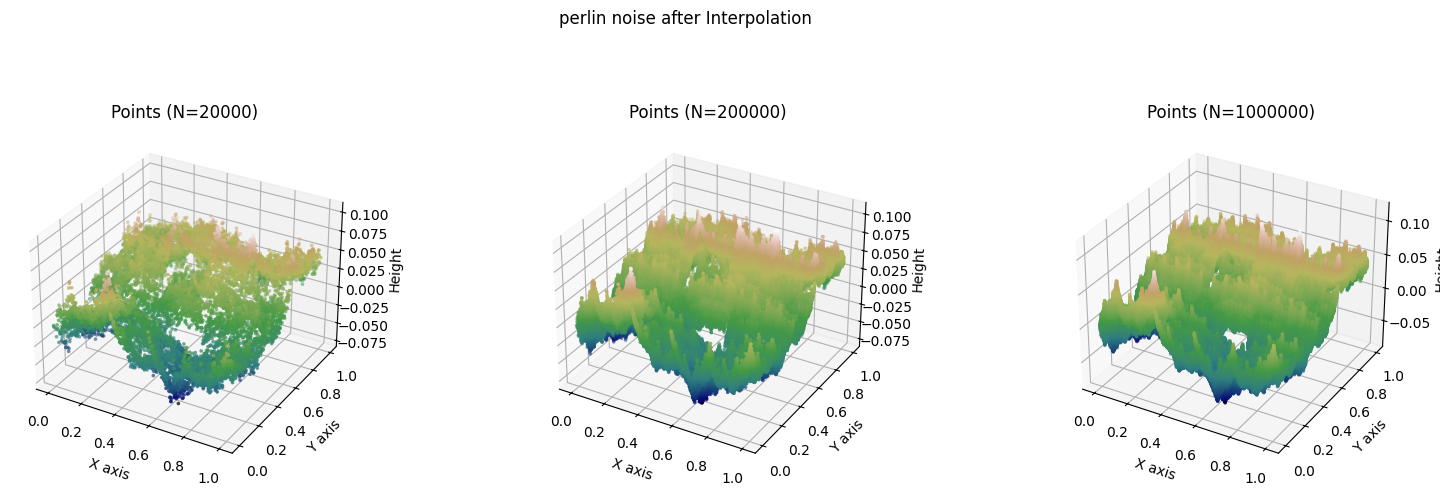

In [36]:
perlin_landscape = perlin(width=1024, height=1024, scale=100.0, octaves=4, persistence=0.5, lacunarity=5.0)
points = interpolate_landscape(perlin_landscape, 3, show_plots=True, Ns=[2e4, 2e5, 1e6], method='perlin noise')

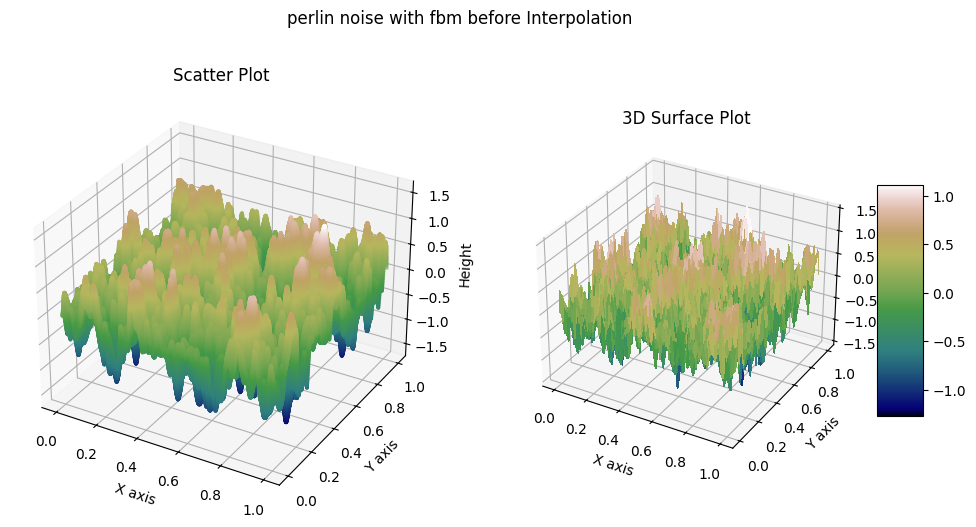

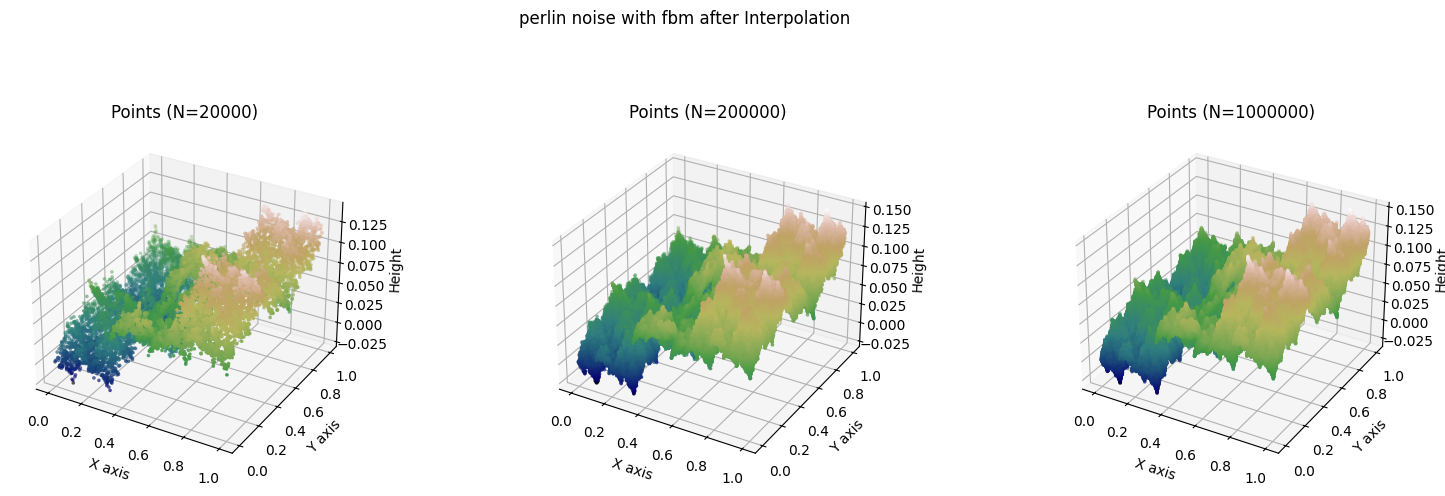

In [37]:
perlin_with_fbm_landscape = perlin_with_fbm(start=200, stop=300, step=0.1, perlin_frequency=0.05, perlin_amplitude=1, fbm_octaves=4, fbm_lacunarity=2, fbm_h=0.1)
points = interpolate_landscape(perlin_with_fbm_landscape, 3, show_plots=True, Ns=[2e4, 2e5, 1e6], method='perlin noise with fbm')

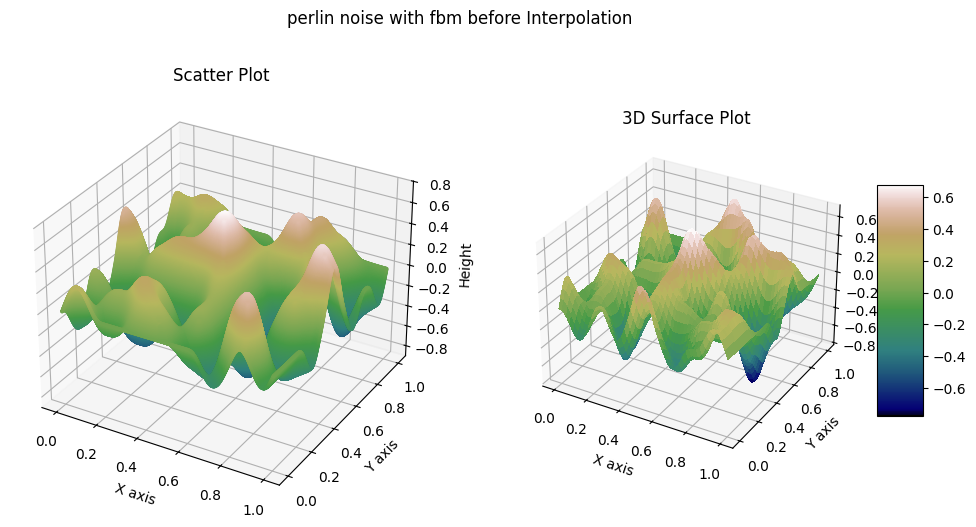

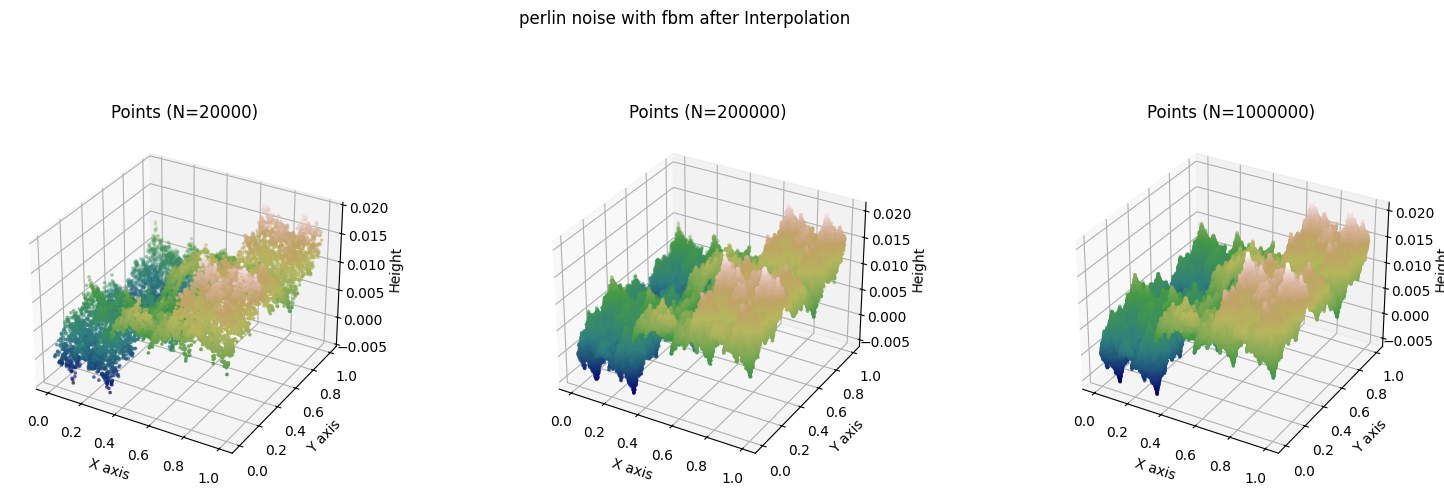

In [38]:
perlin_with_fbm_landscape = perlin_with_fbm(start=200, stop=300, step=0.1, perlin_frequency=0.05, perlin_amplitude=0.5, fbm_octaves=2, fbm_lacunarity=1, fbm_h=1)
points = interpolate_landscape(perlin_with_fbm_landscape, 3, show_plots=True, Ns=[2e4, 2e5, 1e6], method='perlin noise with fbm')

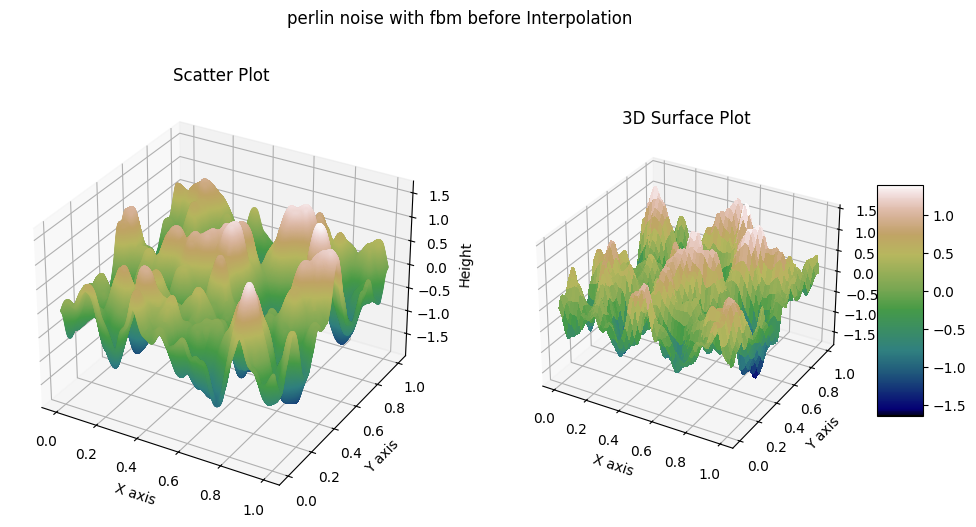

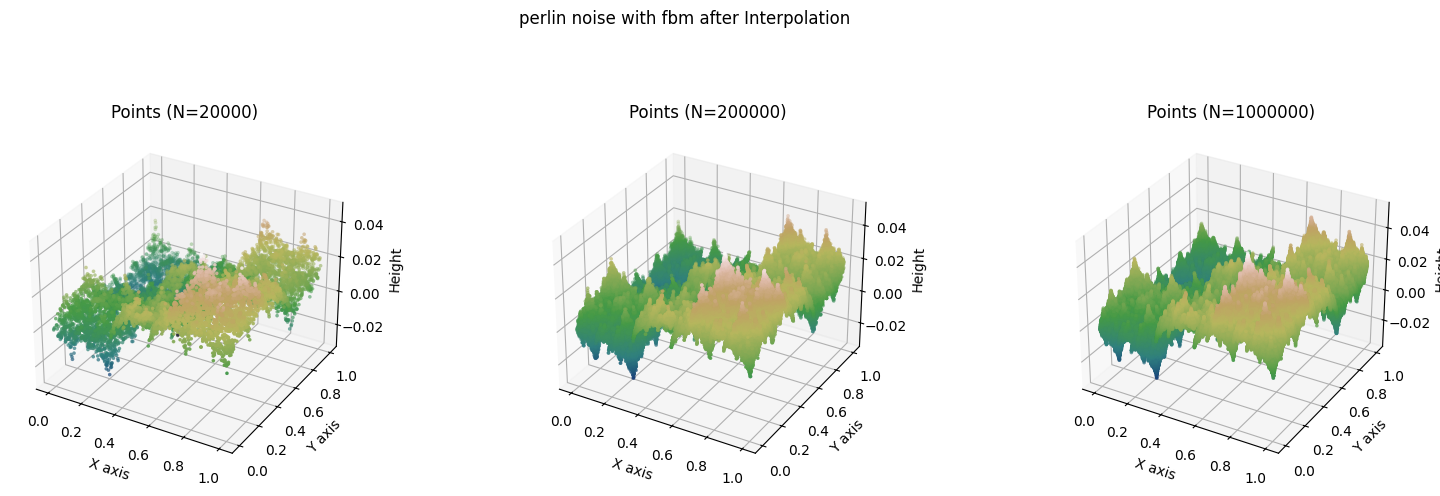

In [39]:
perlin_with_fbm_landscape = perlin_with_fbm(start=200, stop=300, step=0.1, perlin_frequency=0.05, perlin_amplitude=2, fbm_octaves=4, fbm_lacunarity=2, fbm_h=1)
points = interpolate_landscape(perlin_with_fbm_landscape, 3, show_plots=True, Ns=[2e4, 2e5, 1e6], method='perlin noise with fbm')

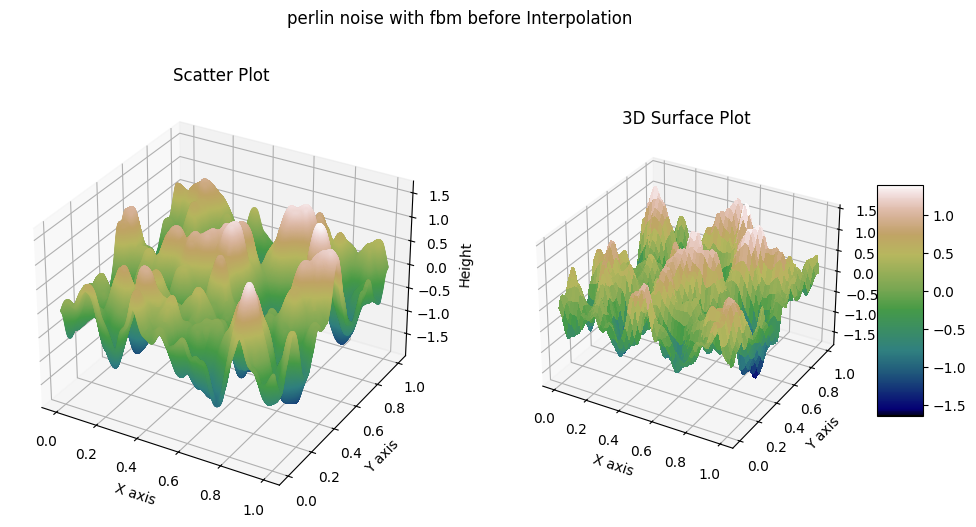

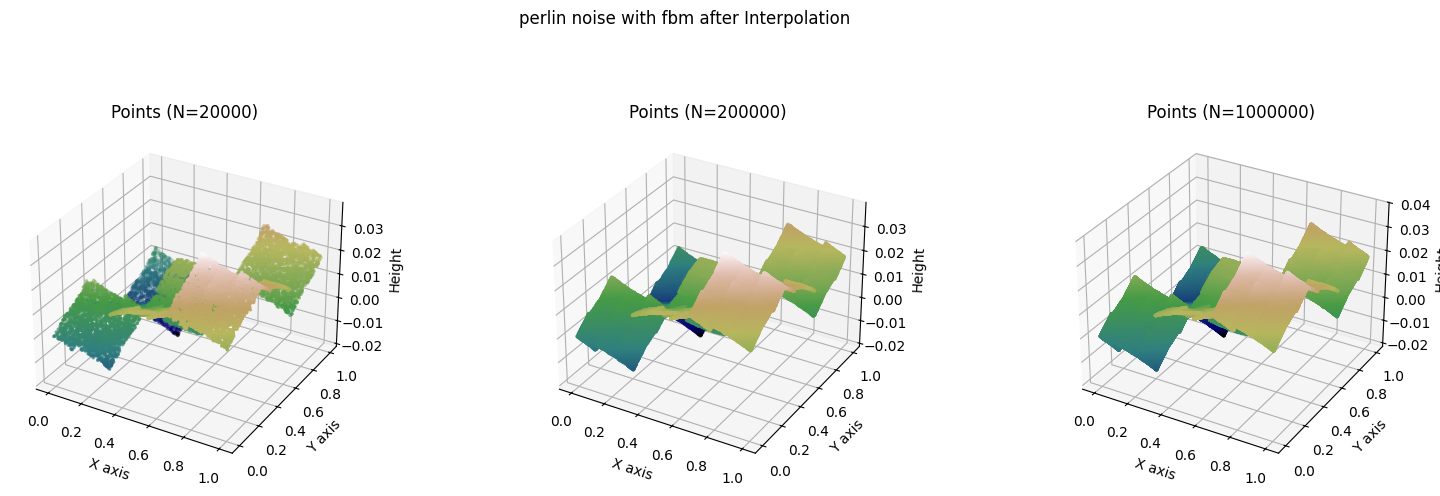

In [40]:
perlin_with_fbm_landscape = perlin_with_fbm(start=200, stop=300, step=0.1, perlin_frequency=0.05, perlin_amplitude=2, fbm_octaves=4, fbm_lacunarity=2, fbm_h=1)
points = interpolate_landscape(perlin_with_fbm_landscape, 3, show_plots=True, Ns=[2e4, 2e5, 1e6], method='perlin noise with fbm', d=0.1)

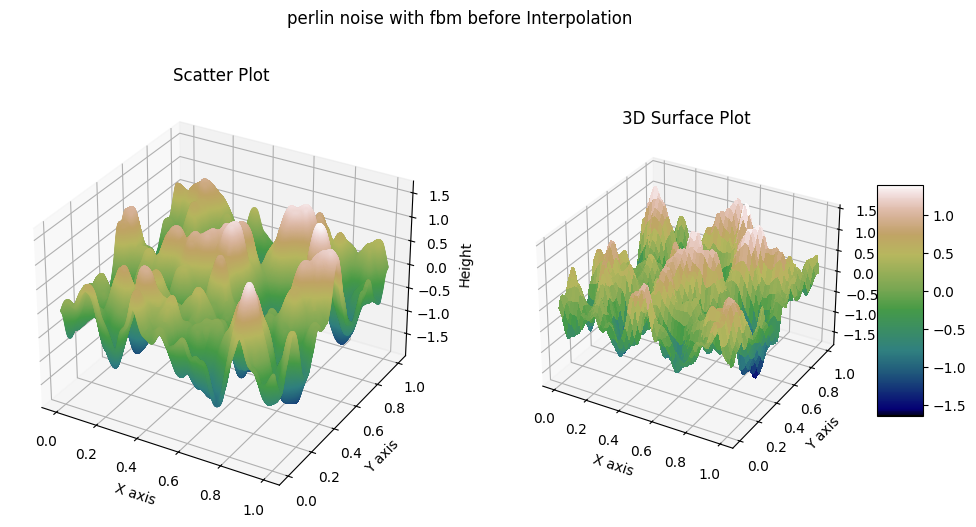

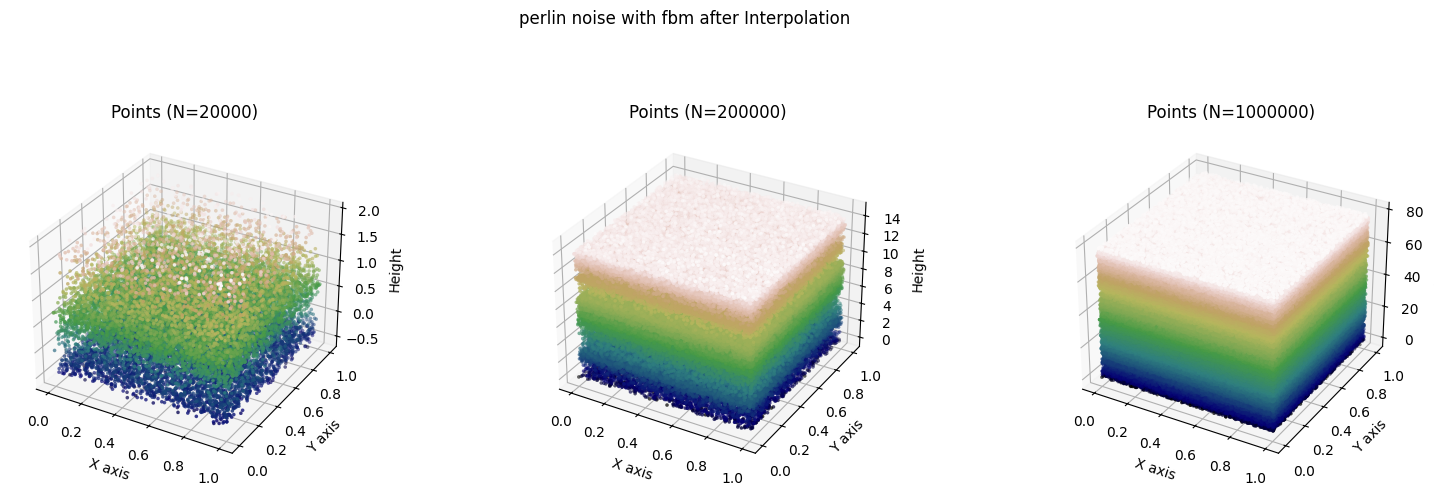

In [41]:
perlin_with_fbm_landscape = perlin_with_fbm(start=200, stop=300, step=0.1, perlin_frequency=0.05, perlin_amplitude=2, fbm_octaves=4, fbm_lacunarity=2, fbm_h=1)
points = interpolate_landscape(perlin_with_fbm_landscape, 3, show_plots=True, Ns=[2e4, 2e5, 1e6], method='perlin noise with fbm', d=1)

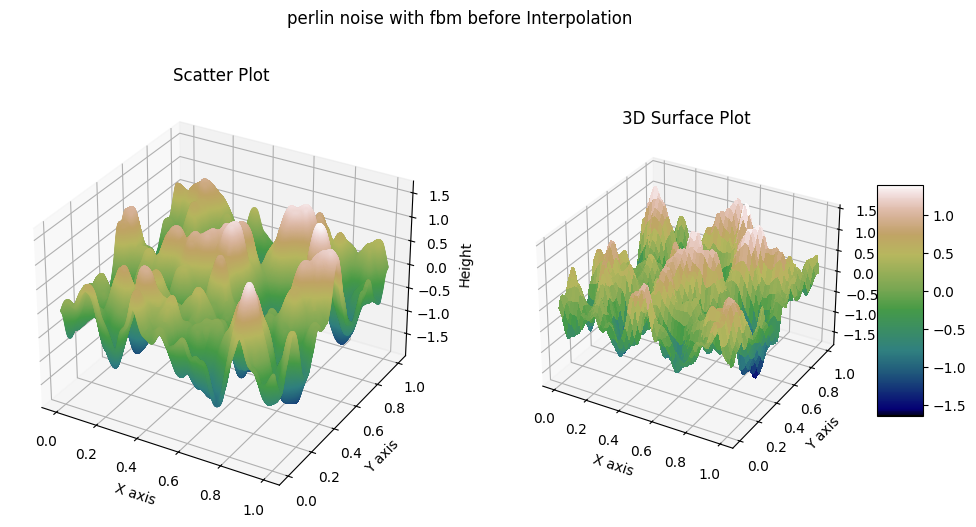

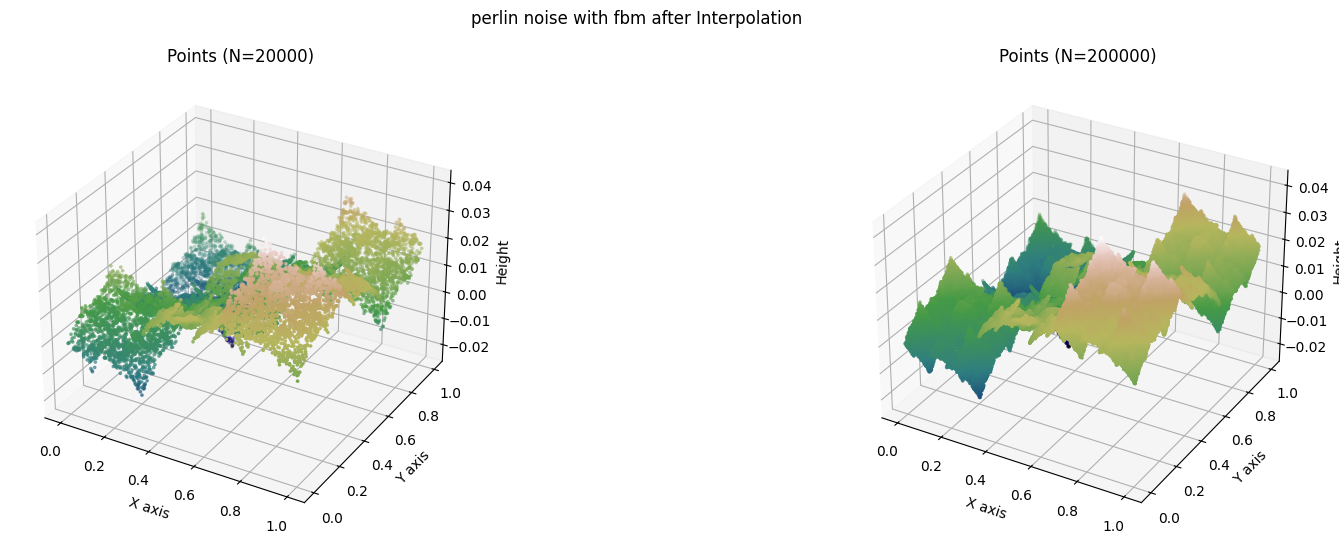

In [42]:
perlin_with_fbm_landscape = perlin_with_fbm(start=200, stop=300, step=0.1, perlin_frequency=0.05, perlin_amplitude=2, fbm_octaves=4, fbm_lacunarity=2, fbm_h=1)
points = interpolate_landscape(perlin_with_fbm_landscape, 3, show_plots=True, Ns=[2e4, 2e5], method='perlin noise with fbm', d=0.3)

# Fractal dimension

In [43]:
def plot_reg(logs, logN, slope, intercept):
    
    # Rysowanie punktów
    plt.scatter(logs, logN, color='blue', label='Punkty danych')
    
    # Rysowanie linii regresji
    plt.plot(logs, slope * logs + intercept, color='red', label=f'Regresja: y = {slope:.2f}x + {intercept:.2f}')
    plt.xlabel('log(epsilons)')
    plt.ylabel('log(N)')
    plt.legend()
    plt.title('Regresja liniowa dla wymiaru boxowego')
    plt.show()
    
    return

def compute_box_dimension_3D_surface(X, epsilons, show_plots=False):
    counts = []
    eps = []
    
    for epsilon in epsilons:
        intervals = int(1 / epsilon)
        n_points = int(len(X)/intervals)
        count = 0

        for i in range(int(intervals)):
            for j in range(int(intervals)):
                in_range = int((np.max(X[i*n_points:(i+1)*n_points-1, j*n_points:(j+1)*n_points-1]) - np.min(X[i*n_points:(i+1)*n_points-1, j*n_points:(j+1)*n_points-1])) / epsilon)
                count += in_range

        if count > 0:
            counts.append(count)
            eps.append(epsilon)

    logs = np.log(1/np.array(eps))
    logN = np.log(counts)

    slope, intercept, _, _, _ = linregress(logs, logN)
    if show_plots:
        plot_reg(logs, logN, slope, intercept)
    
    return slope


def compute_box_dimension_3D_cloud(X, epsilons, show_plots=False):
    tree = KDTree(X)
    counts = []
    
    for epsilon in epsilons:
        count = 0
        grid_size = 1 / epsilon
        
        # Iterate over the grid cells
        for x in np.arange(0, 1, epsilon):
            for y in np.arange(0, 1, epsilon):
                for z in np.arange(0, 1, epsilon):
                    # Define the bounds of the current cell
                    bounds = [(x, x + epsilon), (y, y + epsilon), (z, z + epsilon)]
                    cell_center = np.array([(x + x + epsilon) / 2, (y + y + epsilon) / 2, (z + z + epsilon) / 2])
                    
                    # Query points in the cell
                    if len(tree.query_ball_point(cell_center, epsilon / 2)) > 0:
                        count += 1
        
        counts.append(count)

    logs = np.log(1 / np.array(epsilons))
    logN = np.log(counts)

    slope, intercept = np.polyfit(logs, logN, 1)
    if show_plots:
        plot_reg(logs, logN, slope, intercept)
    
    return slope

from scipy.sparse import coo_matrix

def compute_box_dimension_3D_sparse(X, epsilons):
    counts = []

    for epsilon in epsilons:
        bins = int(1 / epsilon)
        # Map points to grid indices
        grid_indices = np.floor(X / epsilon).astype(int)

        # Use sparse matrix to count unique grid cells
        unique_cells = coo_matrix((np.ones(len(grid_indices)), 
                                   (grid_indices[:, 0], grid_indices[:, 1], grid_indices[:, 2])),
                                   shape=(bins, bins, bins)).nnz

        counts.append(unique_cells)

    logs = np.log(1 / np.array(epsilons))
    logN = np.log(counts)

    slope, intercept = np.polyfit(logs, logN, 1)
    
    return slope

In [44]:
surfaces = [fbm_landscape, diamond_square_landscape, perlin_landscape, perlin_with_fbm_landscape]
methods = ['fbm', 'diamond square', 'perlin noise', 'perlin noise with fbm']
# epsilons = []
# for i in range(8):
#     epsilons = epsilons + [1/(2**i)]
epsilons = [1/(2**i) for i in range(8)]

Ns = [2e4, 2e5, 1e6]

for surface, method in zip(surfaces, methods):
    print('*'*50)
    print(method)
    print(f'Box dimension for 3D surface: {compute_box_dimension_3D_surface(surface, epsilons)}')
    points = interpolate_landscape(surface, 3, show_plots=False, Ns=Ns)
    for N, point in zip(Ns, points):
        dimension = compute_box_dimension_3D_cloud(point[['x1', 'x2', 'y']].values, epsilons)
        print(f'Box dimension for 3D cloud after interpolation: {dimension}, N={int(N)}')

**************************************************
fbm
Box dimension for 3D surface: 2.4150155717096


C:\Users\Hendrick\AppData\Local\Temp\ipykernel_9456\1651457516.py:67: RuntimeWarning: divide by zero encountered in log
  logN = np.log(counts)


Box dimension for 3D cloud after interpolation: nan, N=20000


C:\Users\Hendrick\AppData\Local\Temp\ipykernel_9456\1651457516.py:67: RuntimeWarning: divide by zero encountered in log
  logN = np.log(counts)


Box dimension for 3D cloud after interpolation: nan, N=200000


C:\Users\Hendrick\AppData\Local\Temp\ipykernel_9456\1651457516.py:67: RuntimeWarning: divide by zero encountered in log
  logN = np.log(counts)


Box dimension for 3D cloud after interpolation: nan, N=1000000
**************************************************
diamond square
Box dimension for 3D surface: 2.387580424223827


C:\Users\Hendrick\AppData\Local\Temp\ipykernel_9456\1651457516.py:67: RuntimeWarning: divide by zero encountered in log
  logN = np.log(counts)


Box dimension for 3D cloud after interpolation: nan, N=20000


C:\Users\Hendrick\AppData\Local\Temp\ipykernel_9456\1651457516.py:67: RuntimeWarning: divide by zero encountered in log
  logN = np.log(counts)


Box dimension for 3D cloud after interpolation: nan, N=200000


C:\Users\Hendrick\AppData\Local\Temp\ipykernel_9456\1651457516.py:67: RuntimeWarning: divide by zero encountered in log
  logN = np.log(counts)


Box dimension for 3D cloud after interpolation: nan, N=1000000
**************************************************
perlin noise
Box dimension for 3D surface: 2.6507707822383937
Box dimension for 3D cloud after interpolation: 1.8861904606348772, N=20000
Box dimension for 3D cloud after interpolation: 2.0319971313607232, N=200000
Box dimension for 3D cloud after interpolation: 2.0693289269366217, N=1000000
**************************************************
perlin noise with fbm
Box dimension for 3D surface: 2.262472353665145
Box dimension for 3D cloud after interpolation: 1.8640776874516738, N=20000
Box dimension for 3D cloud after interpolation: 1.9649526287684844, N=200000
Box dimension for 3D cloud after interpolation: 1.9837203423072751, N=1000000
